In [743]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

Parameters

In [744]:
# main dimensionless parameters
S_ = 4.
E_ = 1.5

# numerical parameters
N = 1000
dt = 0.01
Tfinal = 3
RELAXATION = 0.01
PRECISION = 1E-4

# plotting
N_plots = 32
S_values = [0, 1, 2, 3, 4, 5]
E_values = [0, .5, 1, 1.5, 2]

In [745]:
# set once and for all
B0 = 1. 
L0dot = 1. 
lg = 1.

# additional dimensionless parameters
gamma = 3.
Bmax = 10. * B0
tau = 1. / L0dot
tau_star = .3 / L0dot
gamma_star = 20.
l0 = 1. * lg

# other
rho_g = E_**3.0
Nsteps = int(Tfinal / dt)

Discretization into N segments

In [746]:
x_i = np.zeros((len(S_values), len(E_values), N))
y_i = np.zeros((len(S_values), len(E_values), N))
z_i = np.zeros((len(S_values), len(E_values)), dtype=np.int)

for i_S, S_ in enumerate(S_values):
    for i_E, E_ in enumerate(E_values):
        rho_g = E_**3.0

        theta_i = np.zeros(N)  # angle with respect to horizontal
        kappa_i = np.zeros(N)  # curvature at the end of segment
        kappa_star = np.zeros(N)  # intrinsic curvature
        l_i = np.ones(N) * l0 / N   # segment length 
        B_i = np.ones(N) * B0  # bending rigidity
        age_i = np.zeros(N)    # age out of growth zone

        V_i = np.zeros(N - 1)  # mean vertical force on (i-1)th and ith segments
        M_i = np.zeros(N)  # moment exerted by ith segment onto (i-1)th
        theta_temp = np.zeros(N)
        costheta = np.zeros(N)


        for t in range(Nsteps):
            if t % 100 == 0: 
                print("Time %2.2f  | apex angle %2.2f" % (t * dt, theta_i[-1]))

            # find growth zone and update l_i, age_i, B_i
            z = np.sum(np.cumsum(l_i[::-1])[::-1] > lg)
            if z > N - 2:
                raise Exception("Space resolution not sufficient. Try increasing N.")
            age_i[:z] += dt
            B_i = Bmax - (Bmax - B0) * np.exp(-age_i / tau)
            l_i[z:] *= 1 + L0dot * dt
            Ldot = np.exp(- age_i / tau_star)
            #l_i *= 1 + Ldot * dt

            # update kappa, kappa_star
            costheta[:-1] = (theta_i[:-1] + theta_i[1:]) / 2 
            costheta = np.cos(costheta)
            kappa_star[z:] += dt * L0dot * gamma * (- kappa_i[z:] + S_ * costheta[z:] / lg) 
            kappa_star[:z] += dt * Ldot[:z] * gamma_star * (kappa_i[:z] - kappa_star[:z])
            #kappa_star += dt * Ldot * gamma * (- kappa_i + S_ * costheta)  
            kappa_star[-1] = 0  

            counter = 0
            theta_ = deepcopy(theta_i)
            while True:
                counter += 1
                # update internal force and moments
                V_i = -rho_g * np.cumsum(l_i[:0:-1] + l_i[-2::-1])[::-1] / 2
                dMi = V_i * l_i[1:] * np.cos(theta_[1:])
                M_i[:-1] = np.cumsum(dMi[::-1])[::-1]

                # update angles
                dtheta = l_i * (M_i / B_i + kappa_star)
                theta_temp[1:] = np.cumsum(dtheta[:-1])

                # change angles
                deltatheta = np.abs(theta_temp - theta_)
                if  np.max(deltatheta) > PRECISION:
                    theta_ += RELAXATION * np.minimum(1., 1. / deltatheta) * (theta_temp - theta_)
                else:
                    break
                if counter > 10000 / RELAXATION:
                    raise Exception("It does not converge towards a solution. Try reducing the RELAXATION parameter")

            if counter > 10000:
                print("exiting second loop", counter, "time", t * dt)
            theta_i = deepcopy(theta_)
            kappa_i[:-1] = (theta_i[1:] - theta_i[:-1]) / l_i[1:] 


        print('  > save plot | S ', S_, " |  E ", E_)
        x_i[i_S, i_E] = np.cumsum(l_i * np.cos(theta_i))
        y_i[i_S, i_E] = np.cumsum(l_i * np.sin(theta_i))
        z_i[i_S, i_E] = z


Time 0.00  | apex angle 0.00
Time 1.00  | apex angle 0.00
Time 2.00  | apex angle 0.00
  > save plot | S  0  |  E  0
Time 0.00  | apex angle 0.00


<ipython-input-746-3919455c5a74>:60: RuntimeWarning: divide by zero encountered in true_divide
  theta_ += RELAXATION * np.minimum(1., 1. / deltatheta) * (theta_temp - theta_)


Time 1.00  | apex angle -0.18
Time 2.00  | apex angle -0.40
  > save plot | S  0  |  E  0.5
Time 0.00  | apex angle 0.00
Time 1.00  | apex angle -1.05
Time 2.00  | apex angle -1.46
  > save plot | S  0  |  E  1
Time 0.00  | apex angle 0.00
Time 1.00  | apex angle -1.49
Time 2.00  | apex angle -1.57
  > save plot | S  0  |  E  1.5
Time 0.00  | apex angle 0.00
Time 1.00  | apex angle -1.55
Time 2.00  | apex angle -1.57
  > save plot | S  0  |  E  2
Time 0.00  | apex angle 0.00
Time 1.00  | apex angle 1.26
Time 2.00  | apex angle 1.47
  > save plot | S  1  |  E  0
Time 0.00  | apex angle 0.00
Time 1.00  | apex angle 1.18
Time 2.00  | apex angle 1.39
  > save plot | S  1  |  E  0.5
Time 0.00  | apex angle 0.00
Time 1.00  | apex angle 0.23
Time 2.00  | apex angle -0.26
  > save plot | S  1  |  E  1
Time 0.00  | apex angle 0.00
Time 1.00  | apex angle -1.03
Time 2.00  | apex angle -1.40
  > save plot | S  1  |  E  1.5
Time 0.00  | apex angle 0.00
Time 1.00  | apex angle -1.38
Time 2.00  | ap

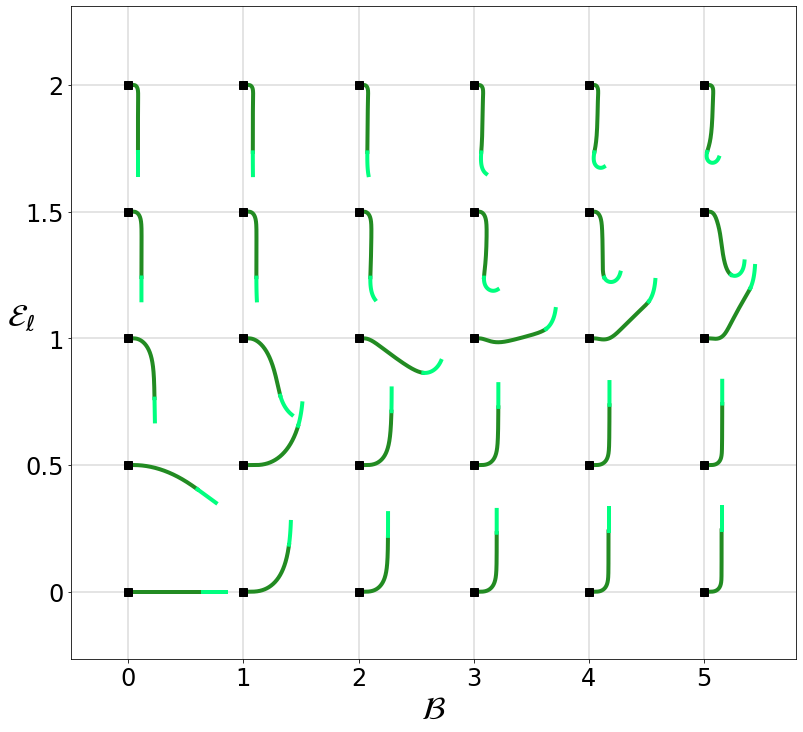

In [917]:
plt.rcParams['figure.figsize'] = [13, 12]

for i_E, E_ in enumerate(E_values):
    plt.plot([-20, 40], [5.5*i_E, 5.5*i_E], 'gainsboro')
for i_S, S_ in enumerate(S_values):
    plt.plot([5*i_S, 5*i_S], [-10, 50], 'gainsboro')
    for i_E, E_ in enumerate(E_values):
        plt.plot(0.25 + 5*i_S + x_i[i_S, i_E,:z_i[i_S, i_E]], 5.5*i_E + y_i[i_S, i_E,:z_i[i_S, i_E]], 'forestgreen', linewidth=4);
        plt.plot(0.25 + 5*i_S + x_i[i_S, i_E,z_i[i_S, i_E]:], 5.5*i_E + y_i[i_S, i_E,z_i[i_S, i_E]:], 'springgreen', linewidth=4);
        plt.plot(5*i_S, 5.5*i_E, 'sk', markersize=8)

plt.axis('equal');
plt.xlim((-2.5,29))
plt.ylim((-2.5,25))

plt.xticks(5*np.array(S_values), S_values, fontsize=24)
plt.yticks(11*np.array(E_values), E_values, fontsize=24)
plt.xlabel('$\mathcal{B}$', fontsize=32)
plt.ylabel('$\mathcal{E}_\ell$', fontsize=32, rotation=0)

plt.savefig('Maha.pdf')  

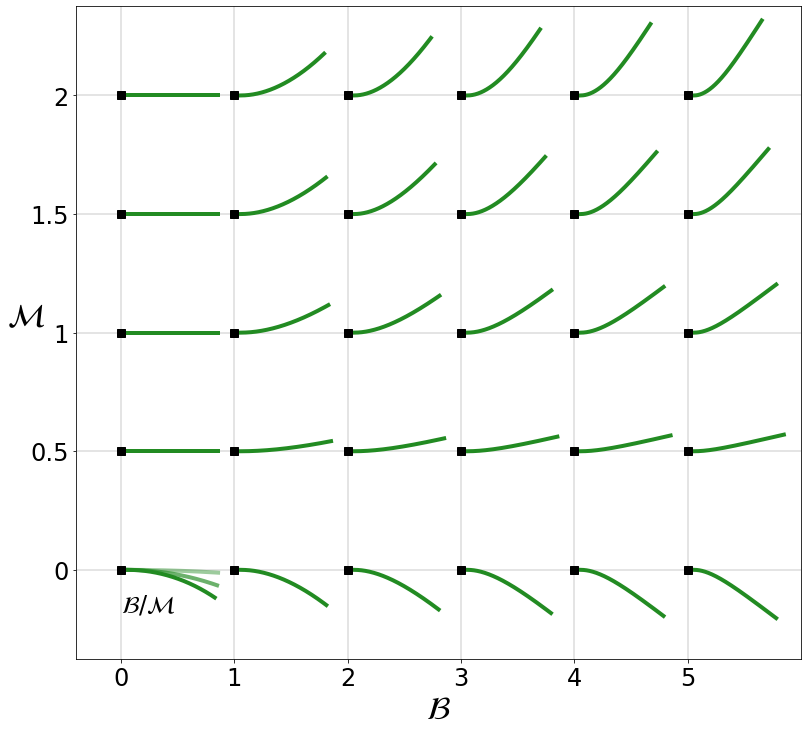

In [916]:
plt.rcParams['figure.figsize'] = [13, 12]
Ap = -.666666667 * np.pi 

s = np.linspace(0,1,N)
B_values = [0, 1, 2, 3, 4, 5]
M_values = [0, 0.5, 1, 1.5, 2]
MsB_values = [0.1, 1, 10]

for i_M, M in enumerate(M_values):
    plt.plot([-20, 40], [1.*i_M, 1.*i_M], 'gainsboro')
for i_B, B in enumerate(B_values):
    plt.plot([1.25*i_B, 1.25*i_B], [-10, 50], 'gainsboro')
    
alpha = 1.0
for MsB in MsB_values:
    A = (-np.pi/2 - Ap) * (1 - s * 1 / (1 + MsB)) + Ap
    x = np.cumsum(-np.sin(A)) / N
    y = np.cumsum(np.cos(A)) / N
    plt.plot(x + 0.07, y, 'forestgreen', linewidth=4, alpha=alpha)
    alpha *= 0.6667


for i_B, B in enumerate(B_values):
    for i_M, M in enumerate(M_values): 
        if i_M==0 and i_B==0:
            pass
        else:
            A = (-np.pi/2 - Ap  / (1 + M)) * (np.exp(-B * s) - np.exp(-B) * (1 - np.exp(-B * s)) / (M + 1 - np.exp(-B))) + Ap / (1 + M)
            x = np.cumsum(-np.sin(A)) / N
            y = np.cumsum(np.cos(A)) / N
            plt.plot(1.25 * i_B + x + 0.07, 1. * i_M + y, 'forestgreen', linewidth=4)

        plt.plot(1.25 * i_B, 1. * i_M, 'sk', markersize=8)

        
#plt.axis('equal');
plt.xlim((-.5,7.5))
plt.ylim((-.75,4.75))

plt.xticks(1.25*np.array(B_values), B_values, fontsize=24)
plt.yticks(2*np.array(M_values), M_values, fontsize=24)
plt.xlabel('$\mathcal{B}$', fontsize=32)
plt.ylabel('$\mathcal{M}$', fontsize=32, rotation=0)
plt.text(0., -0.35, '$\mathcal{B} / \mathcal{M}$', fontsize=24)
#plt.arrow(0.7, -0.1, -0.2, 0.4, head_width=0.05, head_length=0.1, fc='k', ec='k')

#plt.savefig('Ap_minus_pi.pdf')  
plt.savefig('Ap_2pi_3.pdf')  